# DeepDream
DeepDream is an artistic image-modification technique that uses the representations learned by convolutional neural networks. It was first released by Google in the summer of 2015, as an implementation written using the Caffe deep-learning library (this
was several months before the first public release of TensorFlow).4 It quickly became an internet sensation thanks to the trippy pictures it could generate, full of algorithmic pareidolia artifacts, bird feathers, and dog eyes—a byproduct of the fact that the DeepDream convnet was trained on ImageNet, where dog breeds and bird species are vastly overrepresented.

The DeepDream algorithm is almost identical to the convnet filter-visualization technique, consisting of running a convnet in reverse: doing gradient ascent on the input to the convnet in order to maximize the activation of a
specific filter in an upper layer of the convnet. DeepDream uses this same idea, with a few simple differences:
 - With DeepDream, we try to maximize the activation of entire layers rather than that of a specific filter, thus mixing together visualizations of large numbers of features at once.
 - We start not from blank, slightly noisy input, but rather from an existing image—thus the resulting effects latch on to preexisting visual patterns, distorting elements of the image in a somewhat artistic fashion.
 - The input images are processed at different scales (called *octaves*), which improves the quality of the visualizations.
 

### Implement DeepDream in Keras
We’ll start from a convnet pretrained on ImageNet. In Keras, many such convnets are available: `VGG16`, `VGG19`, `Xception`, `ResNet50`, and so on. You can implement Deep- Dream with any of them, but your convnet of choice will naturally affect your visualizations, because different convnet architectures result in different learned features. The convnet used in the original DeepDream release was an Inception model, and in practice Inception is known to produce nice-looking DeepDreams, so we’ll use the Inception V3 model that comes with Keras.

### Load The Pretrained Inception V3 Model

In [30]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)  #We won’t be training the model, so this command disables all trainingspecific operations.

model= inception_v3.InceptionV3(weights='imagenet', include_top=False) #Builds the Inception V3 network, without its 
                                                                       #convolutional base. The model will be loaded with
                                                                       #pretrained ImageNet weights.


Next, we’ll compute the loss: the quantity we’ll seek to maximize during the gradient-ascent process. For filter visualization, we tried to maximize the value of a specific filter in a specific layer. Here, we’ll simultaneously maximize the activation of all filters in a number of layers. Specifically, we’ll maximize a weighted sum of the L2 norm of the activations of a set of high-level layers. The exact set of layers you choose (as well as their contribution to the final loss) has a major influence on the visuals we’ll be able to produce, so we want to make these parameters easily configurable. Lower layers result in geometric patterns, whereas higher layers result in visuals in which we can recognize some classes from ImageNet (for example, birds or
dogs). We’ll start from a somewhat arbitrary configuration involving four layers—but we’ll definitely want to explore many different configurations later.

### Set Up The DeepDream Configuration

In [57]:
layer_contributions={          #Dictionary mapping layer names to a coefficient quantifying how much the layer’s 
    'mixed2': 5.0,            #activation contributes to the loss you’ll seek to maximize. Note that the layer names are
    'mixed3': 1.0,            #hardcoded in the built-in Inception V3 application. We can list all layer names using 
    'mixed4': 0.0,            #model.summary().
    'mixed5': 0.5
}

Now, let’s define a tensor that contains the loss: the weighted sum of the L2 norm of the activations of the layers in the above listing.

### Define The Loss to be Maximized

In [58]:
layers_dict= dict([(layer.name, layer) for layer in model.layers]) #Creates a dictionary that maps layer names to layer instances
layers_dict

{'input_2': <keras.engine.input_layer.InputLayer at 0x20caf4e7ac8>,
 'conv2d_95': <keras.layers.convolutional.Conv2D at 0x20caf4e7e10>,
 'batch_normalization_95': <keras.layers.normalization.BatchNormalization at 0x20caf4e7c88>,
 'activation_95': <keras.layers.core.Activation at 0x20caf4e7da0>,
 'conv2d_96': <keras.layers.convolutional.Conv2D at 0x20c8762c048>,
 'batch_normalization_96': <keras.layers.normalization.BatchNormalization at 0x20caf50edd8>,
 'activation_96': <keras.layers.core.Activation at 0x20caf50eb00>,
 'conv2d_97': <keras.layers.convolutional.Conv2D at 0x20caf5bde48>,
 'batch_normalization_97': <keras.layers.normalization.BatchNormalization at 0x20caf5fbe10>,
 'activation_97': <keras.layers.core.Activation at 0x20caf660ef0>,
 'max_pooling2d_5': <keras.layers.pooling.MaxPooling2D at 0x20caf683940>,
 'conv2d_98': <keras.layers.convolutional.Conv2D at 0x20caf683f28>,
 'batch_normalization_98': <keras.layers.normalization.BatchNormalization at 0x20cb22d0e48>,
 'activation_

In [59]:
loss=K.variable(0.) #We'll define the loss by adding layer contributions to this scalar variable
for layer_name in layer_contributions:
    coeff= layer_contributions[layer_name]
    activation= layers_dict[layer_name].output #Retrieves the layer’s output

    scaling= K.prod(K.cast(K.shape(activation), 'float32'))
    loss += coeff*K.sum(K.square(activation[:, 2: -2, 2: -2, :]))/scaling  #Adds the L2 norm of the features of a layer
                                        #to the loss. We avoid border artifacts by only involving nonborder pixels in the loss

Next, we can set up the gradient-ascent process.

### Gradient-Ascent Process

In [60]:
dream= model.input #This tensor holds the generated image: the dream

grads= K.gradients(loss, dream)[0]   #Computes the gradients of the dream with regard to the loss

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7) #Normalizes the gradients (important trick)

outputs= [loss, grads]                                 #Sets up a Keras function to retrieve the value of
fetch_loss_and_grads= K.function([dream], outputs)     #the loss and gradients, given an input image

def eval_loss_and_grads(x):
    outs= fetch_loss_and_grads([x])
    loss_value= outs[0]
    grad_values= outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss= None):
    for i in range(iterations):
        loss_value, grad_values= eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('... Loss Value at',i,': ', loss_value)
        x+= step*grad_values
    return x

Finally: the actual DeepDream algorithm. First, we define a list of scales (also called octaves) at which to process the images. Each successive scale is larger than the previous one by a factor of 1.4 (it’s 40% larger): we start by processing a small image and then increasingly scale it up.
![image](https://user-images.githubusercontent.com/13174586/51905645-c28dc800-23e7-11e9-89e7-30ffd9fc6e47.png)

For each successive scale, from the smallest to the largest, we run gradient ascent to maximize the loss we previously defined, at that scale. After each gradient ascent run, we upscale the resulting image by 40%. 

To avoid losing a lot of image detail after each successive scale-up (resulting in increasingly blurry or pixelated images), we can use a simple trick: after each scaleup, we’ll reinject the lost details back into the image, which is possible because we know what the original image should look like at the larger scale. Given a small image size S and a larger image size L, we can compute the difference between the original image resized to size L and the original resized to size S—this difference quantifies the details lost when going from S to L.


### Auxiliary functions

In [61]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img= np.copy(img)
    factors=(1, 
             float(size[0])/img.shape[1], 
             float(size[1])/img.shape[2],
             1)
    
    return scipy.ndimage.zoom(img, factors, order=1)

def save_img(img, fname):
    pil_img= deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def preprocess_image(img_path):       #Util function to open, resize, and format pictures 
    img= image.load_img(img_path)   #into tensors that Inception V3 can process
    img= image.img_to_array(img)
    img= np.expand_dims(img, axis=0)
    img= inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x=x.reshape((3, x.shape[2], x.shape[3]))
        x= x.transpose((1,2,0))
    else:
        x= x.reshape((x.shape[1], x.shape[2],3))
    x/=2
    x+=0.5
    x*=255
    x= np.clip(x, 0, 255).astype('uint8')
    return x

### Running Gradient Ascent Over Different Successive Scales

In [62]:
import numpy as np

#Playing with these hyperparameters will let us achieve new effects
step=0.1           #Gradient ascent step size
num_octave=3       #Number of scales at which to run gradient ascent
octave_scale= 1.4  #Size ratio between scales
iterations=20      #Number of ascent steps to run at each scale

max_loss=10.0      #If the loss grows larger than 10, we’ll interrupt the gradient-ascent process to avoid ugly artifacts

base_path_img='scenery2.jpg'

img= preprocess_image(base_path_img) #Loads the base image into a Numpy array

original_shape= img.shape[1:3]
successive_shapes=[original_shape]
for i in range(1, num_octave):                    #Prepares a list of shape
    shape= tuple([int(dim/(octave_scale**i))      #tuples defining the different
                 for dim in original_shape])      #scales at which to run
    successive_shapes.append(shape)               #gradient ascent
                  
successive_shapes= successive_shapes[::-1]        #Reverses the list of shapes so they’re in increasing order

original_img= np.copy(img)                                 #Resizes the Numpy array of the image
shrunk_original_img= resize_img(img, successive_shapes[0]) #to the smallest scale

for shape in successive_shapes:
    print('Preprocessing image shape', shape)
    img= resize_img(img, shape)                       #Scales up the dream image
    img= gradient_ascent(img, iterations=iterations,    #Runs gradient ascent, 
                        step=step, max_loss=max_loss)   #altering the dream

    upscaled_shrunk_original_img= resize_img(shrunk_original_img, shape) #Scales up the smaller version of the original
                                                                          #image: it will be pixellated
    same_size_original= resize_img(original_img, shape)      #Computes the high-quality version of the original image at this size
    lost_detail= same_size_original - upscaled_shrunk_original_img #The difference between the two is the
                                                                   #detail that was lost when scaling up
    img+= lost_detail                                        #Reinjects lost detail into the dream
    shrunk_original_image= resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')
    
save_img(img, fname='final_dream.png')


Preprocessing image shape (551, 979)
... Loss Value at 0 :  2.3495657
... Loss Value at 1 :  2.5769367
... Loss Value at 2 :  3.4304638
... Loss Value at 3 :  4.9854403
... Loss Value at 4 :  7.0239596


c:\users\soumyama\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


Preprocessing image shape (771, 1371)
... Loss Value at 0 :  3.8349094
Preprocessing image shape (1080, 1920)
... Loss Value at 0 :  6.908636


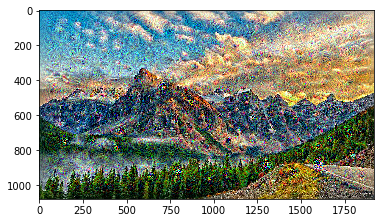

In [63]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

>> **NOTE** Because the original Inception V3 network was trained to recognize concepts in images of size 299 × 299, and given that the process involves scaling the images down by a reasonable factor, the DeepDream implementation produces much better results on images that are somewhere between 300 × 300 and 400 × 400. Regardless, we can run the same code on images of any
size and any ratio.

We strongly suggest to explore by adjusting which layers we use in our loss. Layers that are lower in the network contain more-local, less-abstract representations and lead to dream patterns that look more geometric. Layers that are higher up lead to more-recognizable visual patterns based on the most common objects found in ImageNet, such as dog eyes, bird feathers, and so on. We can use random generation of the parameters in the layer_contributions dictionary to quickly explore many different layer combinations.